In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data

--2025-02-28 02:32:51--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   107MB/s    in 0.5s    

2025-02-28 02:32:52 (107 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]



In [ ]:
!cd data && unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

In [ ]:
%cd data

/content/data


- TV tensors : https://pytorch.org/vision/main/tv_tensors.html

In [ ]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T


# 1. 데이터셋 정의 (PennFudanDataset)
# PennFudan 데이터셋은 보행자 이미지와 각 이미지에 대한 마스크(분할 정보)를 포함합니다.
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        """
        root: 데이터셋의 루트 폴더 (예: './PennFudanPed')
        transforms: 이미지와 타겟에 적용할 변환 함수
        """
        self.root = root
        self.transforms = transforms
        # PNGImages 폴더와 PedMasks 폴더 내의 파일 이름을 정렬해서 리스트로 저장
        self.imgs = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))

    def __getitem__(self, idx):
        # idx번째 이미지와 마스크의 파일 경로 생성
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        # read_image: 이미지를 Tensor 형식으로 읽어옵니다.
        img = read_image(img_path)
        mask = read_image(mask_path)

        # mask 텐서의 유니크한 값(색상 또는 인스턴스 번호)을 추출합니다.
        # 첫 번째 값은 배경이므로 제거합니다.
        obj_ids = torch.unique(mask)[1:]

        # 각 객체 인스턴스에 대해 binary mask를 생성합니다.
        # mask == obj_ids[:, None, None]는 각 인스턴스마다 True/False 마스크를 만듭니다.
        # .to(dtype=torch.uint8)로 자료형을 8비트 정수형으로 변환합니다.
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # masks_to_boxes: 각 binary mask에서 바운딩 박스([x_min, y_min, x_max, y_max]) 계산
        boxes = masks_to_boxes(masks)

        # PennFudan 데이터셋은 보행자만 있으므로, 모든 객체에 1번 라벨을 부여합니다.
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)

        # 이미지 id는 단순히 idx 값을 사용 (평가 시 사용)
        image_id = idx

        # 각 바운딩 박스의 면적 계산: (x_max - x_min) * (y_max - y_min)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # 모든 객체는 군집(crowd)이 아니라고 가정하여 0으로 설정합니다.
        iscrowd = torch.zeros((len(obj_ids),), dtype=torch.int64)

        # tv_tensors를 사용하여 이미지와 타겟을 래핑합니다.
        # 이는 torchvision의 최신 변환 및 시각화 기능을 사용하기 위함입니다.
        img = tv_tensors.Image(img)
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)),
            "masks": tv_tensors.Mask(masks),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # 만약 변환(transforms)이 있다면 적용 (예: 데이터 증강)
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        # 데이터셋의 전체 이미지 수 반환
        return len(self.imgs)


In [ ]:
# 2. 데이터 변환 함수 정의

def get_transform(train):
    """
    train: True이면 학습용 변환을, False이면 검증용 변환을 적용합니다.
    """
    transforms = []
    if train:
        # 학습 시 좌우 반전(data augmentation)을 50% 확률로 적용
        transforms.append(T.RandomHorizontalFlip(0.5))
    # 이미지를 float형으로 변환하고 0~1 범위로 스케일 조정
    transforms.append(T.ToDtype(torch.float, scale=True))
    # Tensor로 변환 (이미 ToDtype에서 텐서가 유지되지만, 혹시 모를 변환을 위해 추가)
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


현재 `torchvision.models.detection.maskrcnn_resnet50_fpn` 모델은 COCO 데이터셋으로 학습되어 있으나, `PennFudanDataset`은 배경과 객체만 구분하므로 모델을 수정해주어야 합니다.

1. **COCO 데이터셋과 클래스 수 차이**  
   - COCO 데이터셋은 약 91개의 객체 클래스로 학습되어 있습니다.  
   - 여러분의 데이터셋(예제에서는 PennFudan)에서는 보통 배경(0)과 실제 객체(예: 보행자만 있다면 1) 또는 다른 소수의 클래스를 사용합니다.  
   - 따라서, 기존의 분류기(head)는 COCO의 클래스 수에 맞게 설계되어 있으므로, 여러분의 데이터셋에 맞게 새롭게 구성할 필요가 있습니다.

2. **박스 예측기(Box Predictor) 교체**  
   - 모델의 `roi_heads.box_predictor`는 객체의 바운딩 박스를 예측하고, 객체 클래스에 대한 점수를 산출합니다.  
   - 이 계층은 COCO에 맞게 학습되어 있기 때문에, 여러분의 데이터셋에 맞는 클래스 수(예: 3개: 배경 + 2개 클래스)로 출력 차원을 변경해야 합니다.  
   - `FastRCNNPredictor`를 사용하여 새롭게 구성함으로써, 입력 피처 수는 그대로 사용하지만 최종 출력 뉴런의 수가 `num_classes`에 맞게 설정됩니다.

3. **마스크 예측기(Mask Predictor) 교체**  
   - Mask R-CNN은 각 객체의 분할 마스크도 예측하는데, 이때 사용되는 `roi_heads.mask_predictor` 역시 COCO용으로 설계되어 있습니다.  
   - 여러분의 데이터셋에서 사용되는 클래스 수에 맞게 마스크 예측기의 출력 채널을 변경해야 합니다.  
   - `MaskRCNNPredictor`를 사용하여 새롭게 구성하면, 마찬가지로 입력 채널 수는 그대로 유지하면서 최종 출력이 여러분이 원하는 클래스 수에 맞게 조정됩니다.

4. **모델 파인튜닝의 목적**  
   - 사전 학습된 모델의 대부분의 레이어(특히, 백본과 FPN)는 일반적인 특징 추출에 강력하기 때문에 그대로 사용합니다.  
   - 하지만, 마지막에 위치한 분류기와 마스크 예측기는 데이터셋마다 클래스 수가 다르므로 반드시 교체해 주어야 합니다.
   - 이렇게 하면 사전 학습된 가중치를 활용하면서도, 여러분의 특정 데이터셋에 최적화된 결과를 얻을 수 있습니다.

요약하면,  
- **분류기와 마스크 예측기를 교체하는 이유는**: 기존 모델이 COCO 데이터셋에 맞춰 학습되었기 때문에 출력 클래스 수가 여러분의 데이터셋과 다르기 때문입니다.  
- **FastRCNNPredictor와 MaskRCNNPredictor를 사용하는 이유는**: 기존의 마지막 계층을 여러분의 클래스 수에 맞춰 재구성하여, 사전 학습된 모델의 강점을 그대로 활용하면서도 올바른 출력을 얻기 위함입니다.

In [ ]:
# 3. 모델 정의 (COCO 사전 학습된 Mask R-CNN 사용)

# COCO에서 사전 학습된 Mask R-CNN (ResNet50 FPN 기반) 모델을 사용하여 파인튜닝합니다.
# 이 모델은 객체 검출 및 인스턴스 분할을 모두 수행합니다.
num_classes = 2  # 1 class (person) + background
device = "cuda" if torch.cuda.is_available() else "cpu"

# torchvision에서 COCO 데이터셋으로 사전 학습된 Mask R-CNN 모델 불러오기
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

# -------------------------
# 박스 예측기 (classification head) 교체
# -------------------------
# 모델의 마지막 계층인 box_predictor의 입력 피처 수를 확인합니다.
in_features = model.roi_heads.box_predictor.cls_score.in_features
# FastRCNNPredictor를 사용하여 새롭게 분류기(head)를 생성합니다.
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# -------------------------
# 마스크 예측기 (mask head) 교체
# -------------------------
# mask_predictor의 conv5_mask 레이어의 입력 채널 수 확인
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256  # 마스크 예측기에서 사용할 숨겨진 레이어의 크기
# MaskRCNNPredictor를 사용하여 마스크 분류기(head)를 새롭게 생성합니다.
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# 모델을 선택한 디바이스(CPU 또는 GPU)로 이동
model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
# 4. DataLoader 및 collate_fn 정의

def collate_fn(batch):
    """
    DataLoader에서 배치를 생성할 때, 각 이미지와 타겟을 하나의 튜플로 묶어줍니다.
    """
    return tuple(zip(*batch))

# 데이터셋 준비: PennFudan 데이터셋의 경로와 변환 함수 지정
dataset = PennFudanDataset('./PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('./PennFudanPed', get_transform(train=False))

# 데이터셋을 학습용과 테스트용으로 나눕니다.
# 여기서는 무작위로 선택하여 마지막 50개 이미지를 테스트셋으로 사용합니다.
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# DataLoader 생성: 배치 크기, 셔플 여부, 그리고 collate_fn 지정
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)


In [ ]:
# 5. 간단한 학습 루프 (2 에폭 예시)
# 학습 가능한 파라미터만 모아 옵티마이저에 전달
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# 학습률 스케줄러: 3 에폭마다 학습률을 0.1배 감소
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 2  # 학습 에폭 수
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 전환 (Dropout, BatchNorm 등이 학습 모드로 작동)
    epoch_loss = 0  # 에폭별 손실 누적 변수
    for images, targets in data_loader:
        # 각 이미지와 타겟을 device(GPU 또는 CPU)로 이동
        images = [img.to(device) for img in images]
        # 타겟은 dict 형식이며, tensor인 항목만 to(device) 처리
        targets = [{k: (v.to(device) if torch.is_tensor(v) else v) for k, v in t.items()} for t in targets]

        # 모델에 이미지와 타겟을 전달하면, 학습 모드에서는 손실(loss) dict를 반환합니다.
        loss_dict = model(images, targets)
        # dict의 모든 손실값을 합산하여 총 손실을 계산합니다.
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()  # 손실 값을 float로 누적

        optimizer.zero_grad()  # 이전 배치의 기울기(gradient) 초기화
        losses.backward()      # 역전파를 통해 기울기 계산
        optimizer.step()       # 옵티마이저가 파라미터를 업데이트

    lr_scheduler.step()  # 에폭마다 학습률 업데이트
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("학습 완료!")


Epoch 1/2, Loss: 32.7302
Epoch 2/2, Loss: 16.2409
학습 완료!


In [ ]:
# 6. 평가 및 결과 시각화 (한 이미지 예시)

model.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 등이 평가 모드로 작동)
# 예측할 이미지 파일 경로 지정
image = read_image("./PennFudanPed/PNGImages/FudanPed00046.png")
# 평가용 변환 함수 적용 (학습용 변환이 아닌 검증용 변환 사용)
eval_transform = get_transform(train=False)
with torch.no_grad():
    # eval_transform을 적용하면 이미지 텐서의 shape이 유지됩니다.
    # 여기서 [:3, ...]는 이미지의 처음 3채널(RGB)만 선택합니다.
    x = eval_transform(image)[:3, ...].to(device)
    # 모델에 단일 이미지의 배치를 전달 (배치 크기는 1)
    predictions = model([x])
    pred = predictions[0]



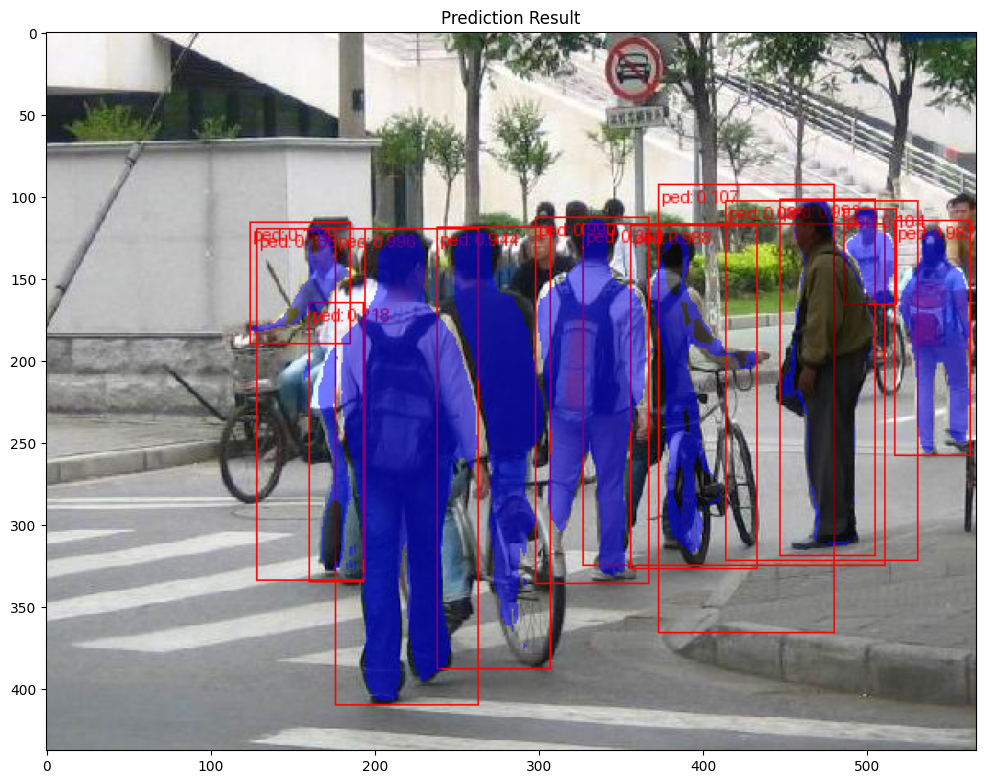

In [ ]:
# 시각화를 위한 전처리: 이미지의 픽셀 값을 0~255 범위로 정규화하여 uint8 타입으로 변환합니다.

# image.min(), image.max()를 이용해 정규화하고 [:3, ...]로 RGB 채널만 선택합니다.
image_vis = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)[:3, ...]
# 예측된 각 박스에 대해, 점수를 포함한 라벨 문자열을 생성합니다.
pred_labels = [f"ped: {score:.3f}" for score in pred["scores"]]
# 예측된 바운딩 박스 좌표를 정수형(long)으로 변환합니다.
pred_boxes = pred["boxes"].long()
# draw_bounding_boxes: 이미지 위에 박스를 그림. output_image는 Tensor 형태로 반환됩니다.
output_image = torchvision.utils.draw_bounding_boxes(image_vis, pred_boxes, pred_labels, colors="red")


# 마스크 예측 결과: 0.7 이상의 확률을 가진 픽셀을 True로 설정합니다.
# squeeze(1)은 마스크 텐서의 차원을 줄여줍니다.
masks = (pred["masks"] > 0.7).squeeze(1)
# draw_segmentation_masks: 이미지 위에 반투명한 색상의 마스크를 그림.
output_image = torchvision.utils.draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


# 결과 시각화: plt.imshow()에 전달하기 전에 채널 순서를 (채널, 높이, 너비)에서 (높이, 너비, 채널)로 변경합니다.
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.title("Prediction Result")
plt.show()
